In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [2]:
import warnings
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid

from grr.Simulation import GIFnet_Simulation
from grr.Tools import PSTH, raiseExpectedGot, timeToIndex
from grr.CurveFit import plot_linear_fit

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
plt.rc('text', usetex=False)
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [4]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network')

sim_dict = {'Mod type': [], 'Condition': [], 'Rep': [], 'Model': []}

for fname in os.listdir(os.path.join(DATA_PATH, 'subsample_base')):
    if fname.endswith(('hdf5', 'h5')) and 'base' in fname and not 'impulse' in fname:
        sim_dict['Mod type'].append('Base')
        sim_dict['Rep'].append(int(re.search(r'rep([0-9]+)', fname).groups()[-1]))

        if 'noGABA' in fname:
            sim_dict['Condition'].append('No GABA')
        elif 'GABA' in fname:
            sim_dict['Condition'].append('Control')
        else:
            sim_dict['Condition'].append('Unknown')

        sim_dict['Model'].append(GIFnet_Simulation(os.path.join(DATA_PATH, 'subsample_base', fname), mode = 'r'))

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Condition,Mod type,Model,Rep
0,Control,Base,"[connectivity_matrix, gaba, ser]",0
1,Control,Base,"[connectivity_matrix, gaba, ser]",1
2,Control,Base,"[connectivity_matrix, gaba, ser]",2
3,Control,Base,"[connectivity_matrix, gaba, ser]",3
4,Control,Base,"[connectivity_matrix, gaba, ser]",4


In [5]:
sim_df['5HT PSTH'] = None
sim_df['5HT PSTH'] = sim_df['5HT PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [6]:
PSTH_width = 25.

for i in range(sim_df.shape[0]):
    print('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, '5HT PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, '5HT PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] == 'No GABA':
        sim_df.loc[i, 'GABA PSTH'] = None
        continue
    else:
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )

Computing PSTH 0.0%
Computing PSTH 5.0%
Computing PSTH 10.0%
Computing PSTH 15.0%
Computing PSTH 20.0%
Computing PSTH 25.0%
Computing PSTH 30.0%
Computing PSTH 35.0%
Computing PSTH 40.0%
Computing PSTH 45.0%
Computing PSTH 50.0%
Computing PSTH 55.0%
Computing PSTH 60.0%
Computing PSTH 65.0%
Computing PSTH 70.0%
Computing PSTH 75.0%
Computing PSTH 80.0%
Computing PSTH 85.0%
Computing PSTH 90.0%
Computing PSTH 95.0%


In [7]:
psth_dict = {'Mod type': [], 'Condition': [], '5HT PSTH': [], 'GABA PSTH': []}
for modtype in sim_df['Mod type'].unique():
    for cond in sim_df['Condition'].unique():
        psth_dict['Mod type'].append(modtype)
        psth_dict['Condition'].append(cond)
        psth_dict['5HT PSTH'].append(np.array(
            sim_df.loc[(sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), '5HT PSTH'].tolist()
        ))
        psth_dict['GABA PSTH'].append(np.array(
            sim_df.loc[(sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'GABA PSTH'].tolist()
        ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [8]:
psth_df.head()

,5HT PSTH,Condition,GABA PSTH,Mod type
0,"[[[0.4666666666666667, 0.4666666666666667, 0.4...",Control,"[[[2.4000000000000004, 2.4000000000000004, 2.4...",Base
1,"[[[0.2, 0.26666666666666666, 0.266666666666666...",No GABA,"[None, None, None, None, None, None, None, Non...",Base


In [9]:
def select_PSTH_dataset(dframe, condition, mod_type, psth_type='5HT PSTH'):
    return dframe.loc[(dframe['Condition'] == condition) & (dframe['Mod type'] == mod_type), psth_type].item()

In [11]:
def get_step_amplitudes(simulation, step_start_time):
    step_start_ind = timeToIndex(step_start_time, 0.1)[0]
    baseline = simulation['ser/examples/I'][..., :step_start_ind].mean()
    return simulation['ser/examples/I'][..., step_start_ind:].mean(axis=2).mean(axis=1) - baseline

def get_pointwise_gain(psth_arr, step_amplitudes, baseline_start_time, step_start_time, dt=0.1):
    """
    Returns
    -------
    (gain, intercept)
    
    """
    assert np.ndim(psth_arr) == 3
    assert np.ndim(step_amplitudes) == 1
    assert np.shape(psth_arr)[1] == len(step_amplitudes)
    
    step_start_ind = timeToIndex(step_start_time, dt)[0]
    step_response = psth_arr[..., step_start_ind:]
    mean_step_response = step_response.mean(axis=0)
    
    baseline_activity = psth_arr[..., timeToIndex(baseline_start_time, dt)[0]:step_start_ind]
    mean_baseline_activity = baseline_activity.mean(axis=0).mean(axis=1)  # Average over sweeps and time.
    assert np.ndim(mean_baseline_activity) == 1
    assert len(mean_baseline_activity) == mean_step_response.shape[0]
    
    coeffs = np.polyfit(step_amplitudes, mean_step_response - mean_baseline_activity[:, np.newaxis], deg=1)
    
    return coeffs[0, :], coeffs[1, :]

In [12]:
step_amplitudes = get_step_amplitudes(sim_df.loc[0, 'Model'], 1000.)

In [31]:
def plot_lines_cmap(x, y, cmap, start=0., stop=1., ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    colors = cmap(np.linspace(start, stop, np.shape(y)[1]))
    for i in range(np.shape(y)[1]):
        ax.plot(x, y[:, i], color=colors[i], **pltargs)

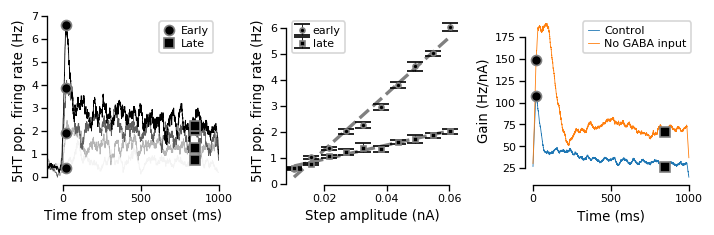

In [40]:
ser_ctrl_psth = select_PSTH_dataset(psth_df, 'Control', 'Base', '5HT PSTH')

ebar_params = {'ls': 'none', 'capsize': 5, 'ecolor': 'k', 'markersize': 3}
markeredgecolor='gray'
cmap = plt.get_cmap('Greys')
stim_start_time = 1000.
peak_ind = 10200
steady_ind = 18500
t_vec = sim_df['Model'][0].get_t_vec() - stim_start_time

spec = gs.GridSpec(1, 3)

plt.figure(figsize=(6, 2))

plt.subplot(spec[:, 0])
plot_lines_cmap(t_vec, ser_ctrl_psth[0, ::3, :].T, cmap, start=0.1)
plt.plot(
    [peak_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[0, ::3, peak_ind], 
    'ko', label='Early', markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[0, ::3, steady_ind], 
    'ks', label='Late', markeredgecolor=markeredgecolor
)
plt.xlim(-100., 1000.)
plt.xlabel('Time from step onset (ms)')
plt.ylabel('5HT pop. firing rate (Hz)')
plt.legend()

plt.subplot(spec[:, 1])
plt.errorbar(
    marker='o',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., peak_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., peak_ind].std(axis=0)/np.sqrt(ser_ctrl_psth.shape[0]),
    label='early',
    **ebar_params
)
plt.errorbar(
    marker='s',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., steady_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., steady_ind].std(axis=0)/np.sqrt(ser_ctrl_psth.shape[0]),
    label='late',
    **ebar_params
)
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., peak_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., steady_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plt.ylabel('5HT pop. firing rate (Hz)')
plt.xlabel('Step amplitude (nA)')
plt.legend()

plt.subplot(spec[:, 2])
ser_gain = get_pointwise_gain(ser_ctrl_psth, step_amplitudes, 500., stim_start_time)[0]
gaba_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'No GABA', 'Base', '5HT PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    ser_gain,
    label='Control'
)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    gaba_gain,
    label='No GABA input'
)
plt.plot(
    [peak_ind * 0.1 - stim_start_time] * 2, 
    [gain_[peak_ind - timeToIndex(stim_start_time, 0.1)[0]] for gain_ in [ser_gain, gaba_gain]],
    'ko',
    markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time] * 2, 
    [gain_[steady_ind - timeToIndex(stim_start_time, 0.1)[0]] for gain_ in [ser_gain, gaba_gain]],
    'ks',
    markeredgecolor=markeredgecolor
)
plt.ylabel('Gain (Hz/nA)')
plt.xlabel('Time (ms)')
plt.legend()

sns.despine(trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_gain_illustration.png'))

del ser_ctrl_psth, ser_gain, gaba_gain